In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.subplots as ps
import matplotlib.pyplot as plt
import matplotlib.colors as mc

In [2]:
metrics = dict()
models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
include = np.arange(10,14)
# 1 is trad_loading
for path in models_path.iterdir():
    if int(path.name[-5:]) not in include:
          continue
    logs_path = path / "mylogger/logger.parquet"

    if not logs_path.exists():
        continue
    df = pd.read_parquet(logs_path)
    df["train_mask"]=df["train_mask_loss"]
    df = df.drop(columns="train_mask_loss")
    df["train_spectral"]=df["train_spectral_loss"]
    df = df.drop(columns="train_spectral_loss")
    df = df.set_index("epoch", drop=True)
    metrics[str(path.name)] = df
sorted_keys = sorted([key for key in metrics.keys()])

In [5]:
# get environment
plot_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/plots")
columns = [
    "pretraining_time",
    "training_time",
    "compile",
    "trad_loading",
    "scale_mask"
    ]
params = pd.DataFrame(columns=columns)
for dir in plot_path.iterdir():
    if int(dir.name[-5:]) not in include:
          continue
    try:
        globs = pd.read_csv(dir/ "globals.csv", delimiter=",").set_index("0", drop=True).T
        available_paras = [n for n in columns if n in globs.columns]
        params.loc[dir.name] = globs[available_paras].iloc[1]
    except FileNotFoundError:
        print(f"globals file for {dir.name} not found!")
params = pd.read_csv(plot_path.parent/"param1.csv", index_col=0)

Text(0.5, 1.0, 'Masking Loss during training with different scale factors')

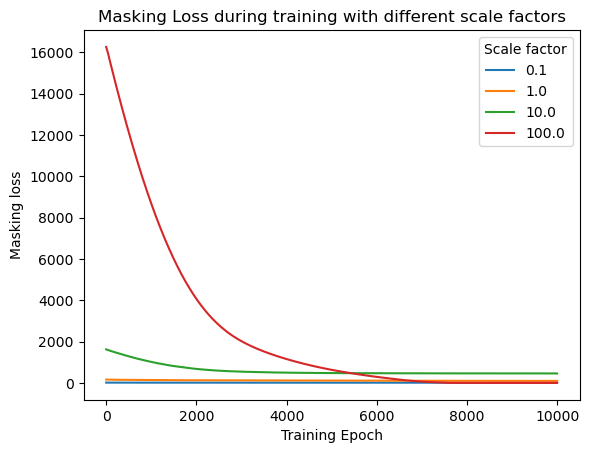

In [6]:

for key in sorted_keys:
    plt.plot(metrics[key].index,
             #np.log(
                 metrics[key]["train_mask"],
                 #),
             label= params.loc[key,"scale_mask"])
plt.legend(title="Scale factor")
plt.ylabel("Masking loss")
plt.xlabel("Training Epoch")
plt.title("Masking Loss during training with different scale factors")
#plt.savefig("./data/figures/logs/masking_loss.pdf")

Text(0.5, 1.0, 'Distance to prior during training with different scale factors')

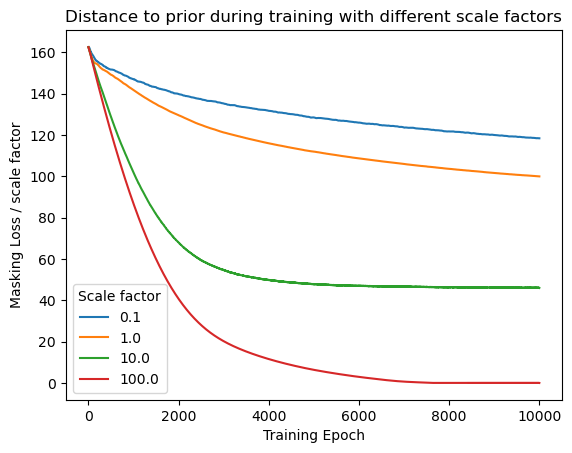

In [7]:
for key in sorted_keys:
    scale_factor = float(params.loc[key,"scale_mask"])
    x=metrics[key].index
    y=metrics[key]["train_mask"]
    plt.plot(x,
             #np.log(
                 y/scale_factor,
                 #),
             label= scale_factor)
plt.legend(title="Scale factor")
plt.ylabel("Masking Loss / scale factor")
plt.xlabel("Training Epoch")
plt.title("Distance to prior during training with different scale factors")
#plt.savefig("./data/figures/logs/prior_distance.pdf")

In [8]:
metrics.keys()

dict_keys(['test_run_00011', 'test_run_00012', 'test_run_00013', 'test_run_00010'])

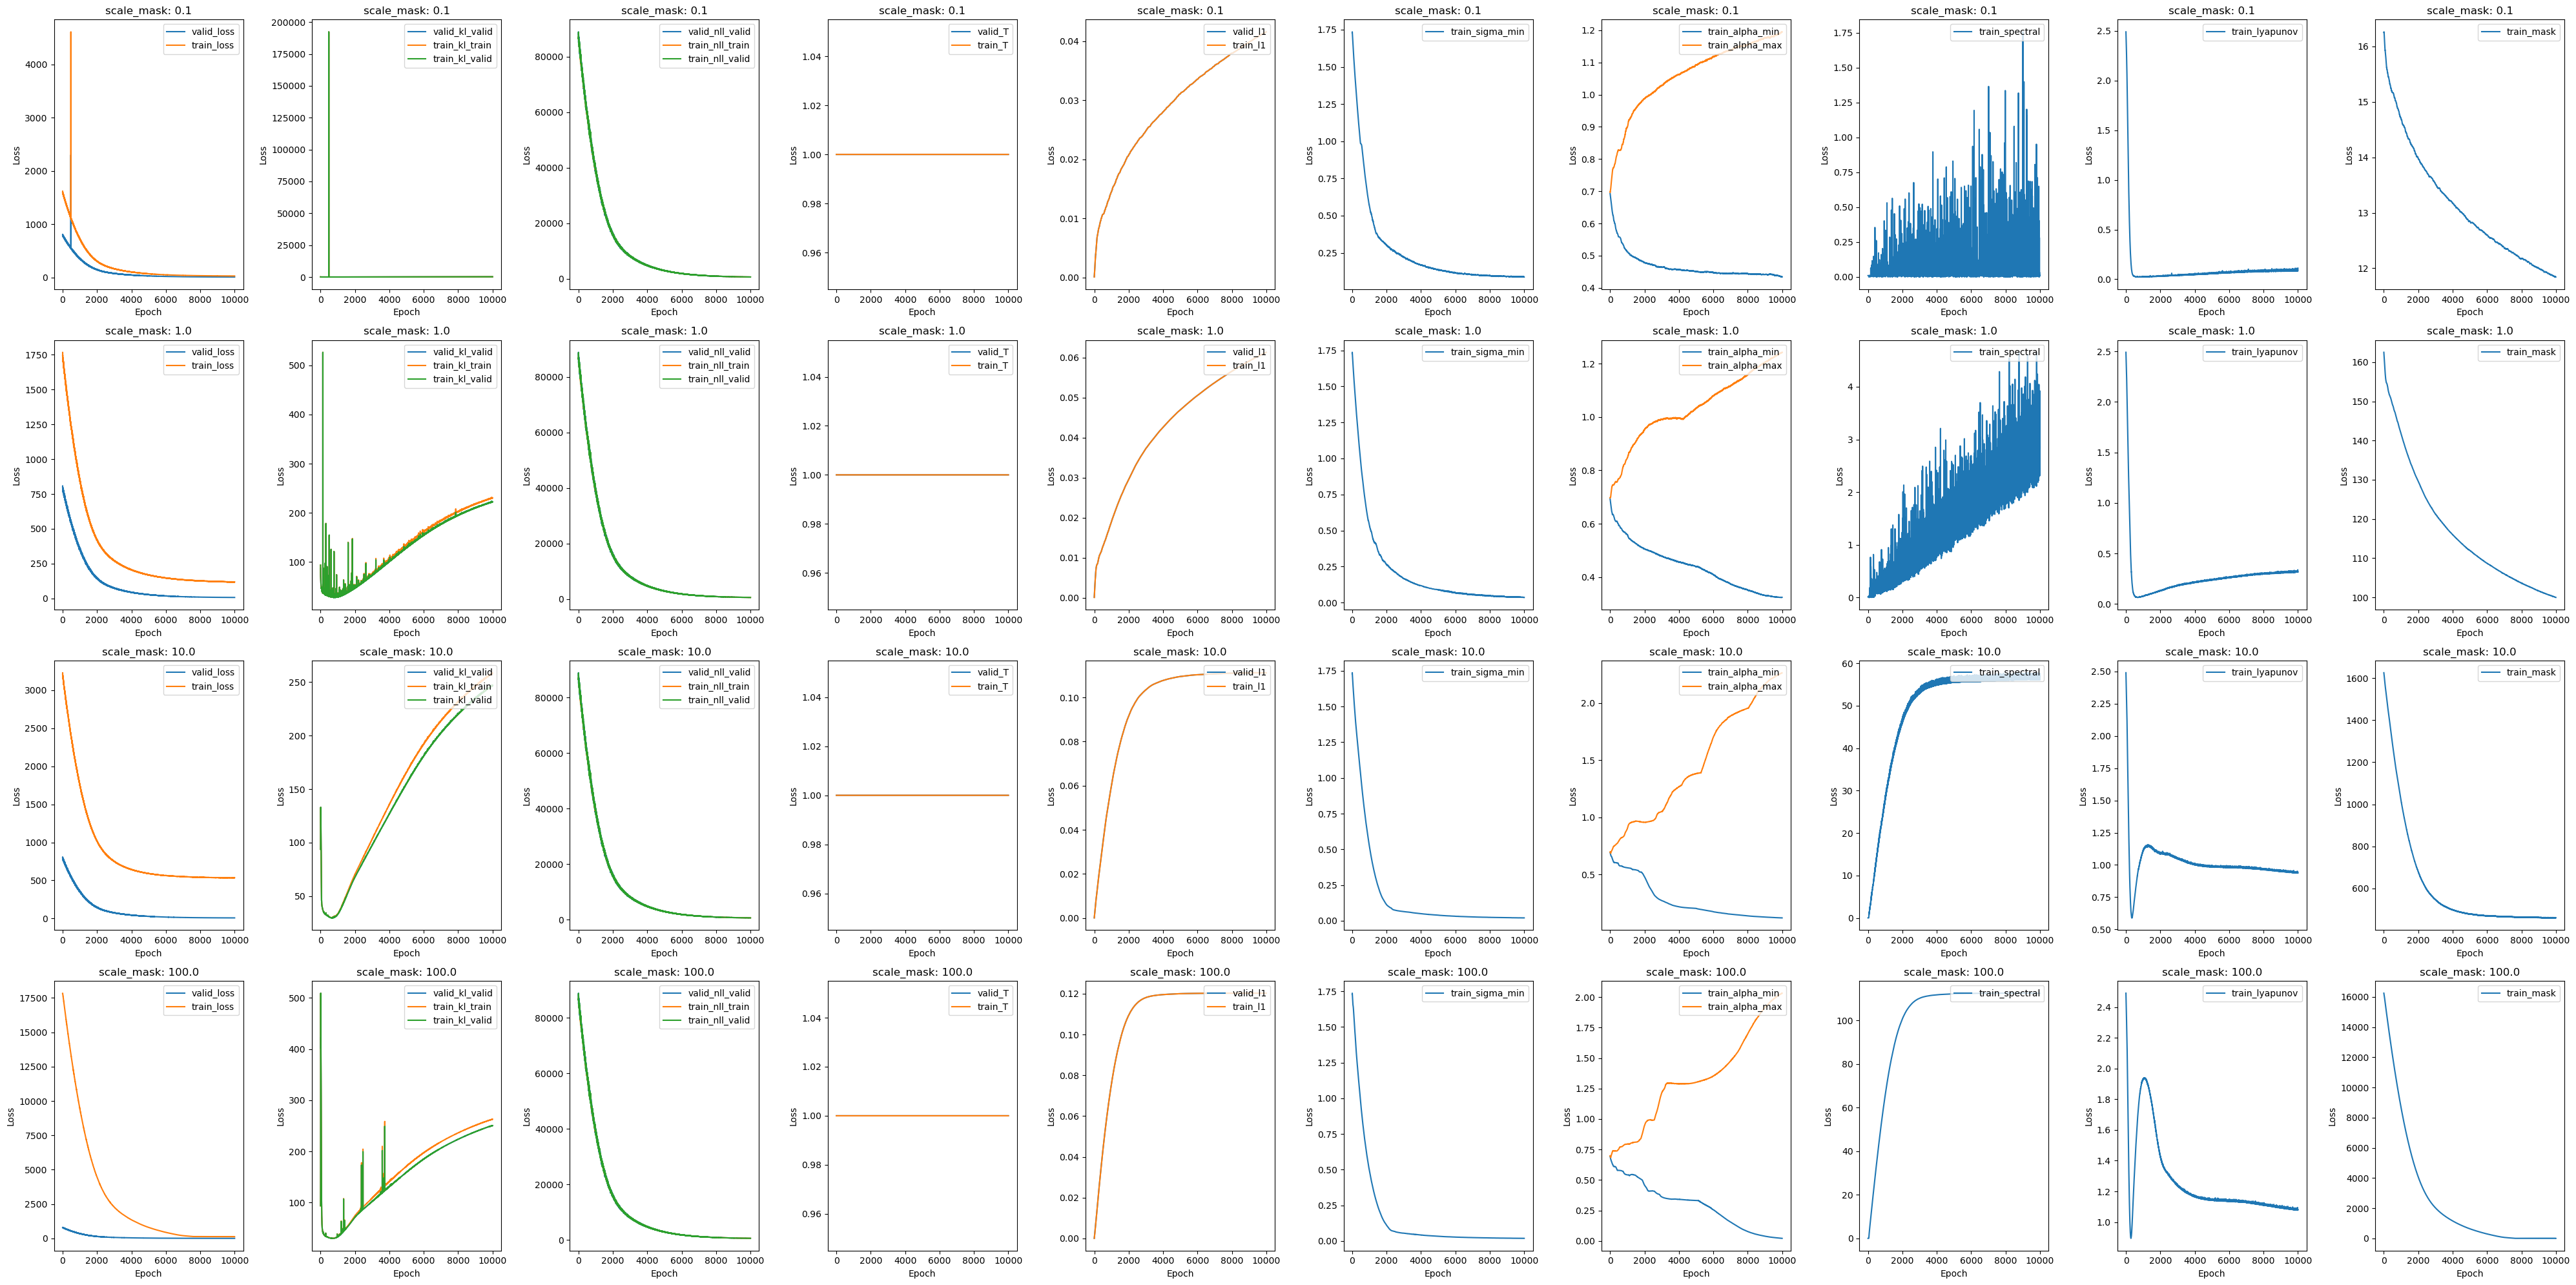

In [ ]:
# plot loss vs validation loss
components = ["loss", "kl", "nll", "T", "l1","sigma", "alpha", "spectral", "lyapunov", "mask"]
fig, ax = plt.subplots(nrows=len(metrics.keys()), ncols=len(components), figsize= (40, 20))
for n, key in enumerate(sorted_keys):
    for c, comp in enumerate(components):
        for x in df.columns:
            if comp in x:
                ax[n, c].plot(
                    metrics[key].index,
                    metrics[key][x],
                    label=x
                )
        #train= comp.replace(".", "train")
        #valid = comp.replace(".", "valid")
        #ax[n, c].plot(
        #    df.index,
        #    df[train],
        #    label=train
        #)
        #ax[n, c].plot(
        #    df.index,
        #    df[valid],
        #    label=valid
        #)
        ax[n, c].legend(loc="upper right")
        ax[n, c].set_ylabel("Loss")
        ax[n, c].set_xlabel("Epoch")
        ax[n, c].set_title("scale_mask: "+str(params.loc[key, "scale_mask"]))
fig.align_xlabels()
fig.set_tight_layout("tight")
fig.show()
#fig.savefig("./data/figures/logs/scalemask_masking_loss_tableau.pdf")

In [ ]:
metrics = dict()
models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
pretraining = True
# 1 is trad_loading
for path in models_path.iterdir():
    logs_path = path / "lightning_logs"
    
    if pretraining:
        logs_path/= "version_0"
    else:
        logs_path/="version_1"
    if not logs_path.exists():
        continue
    df = pd.read_csv(logs_path/"metrics.csv")
    df = df.drop(columns=["step"])
    df = df.groupby("epoch").agg(lambda x: x.dropna())
    metrics[str(path.name)] = df

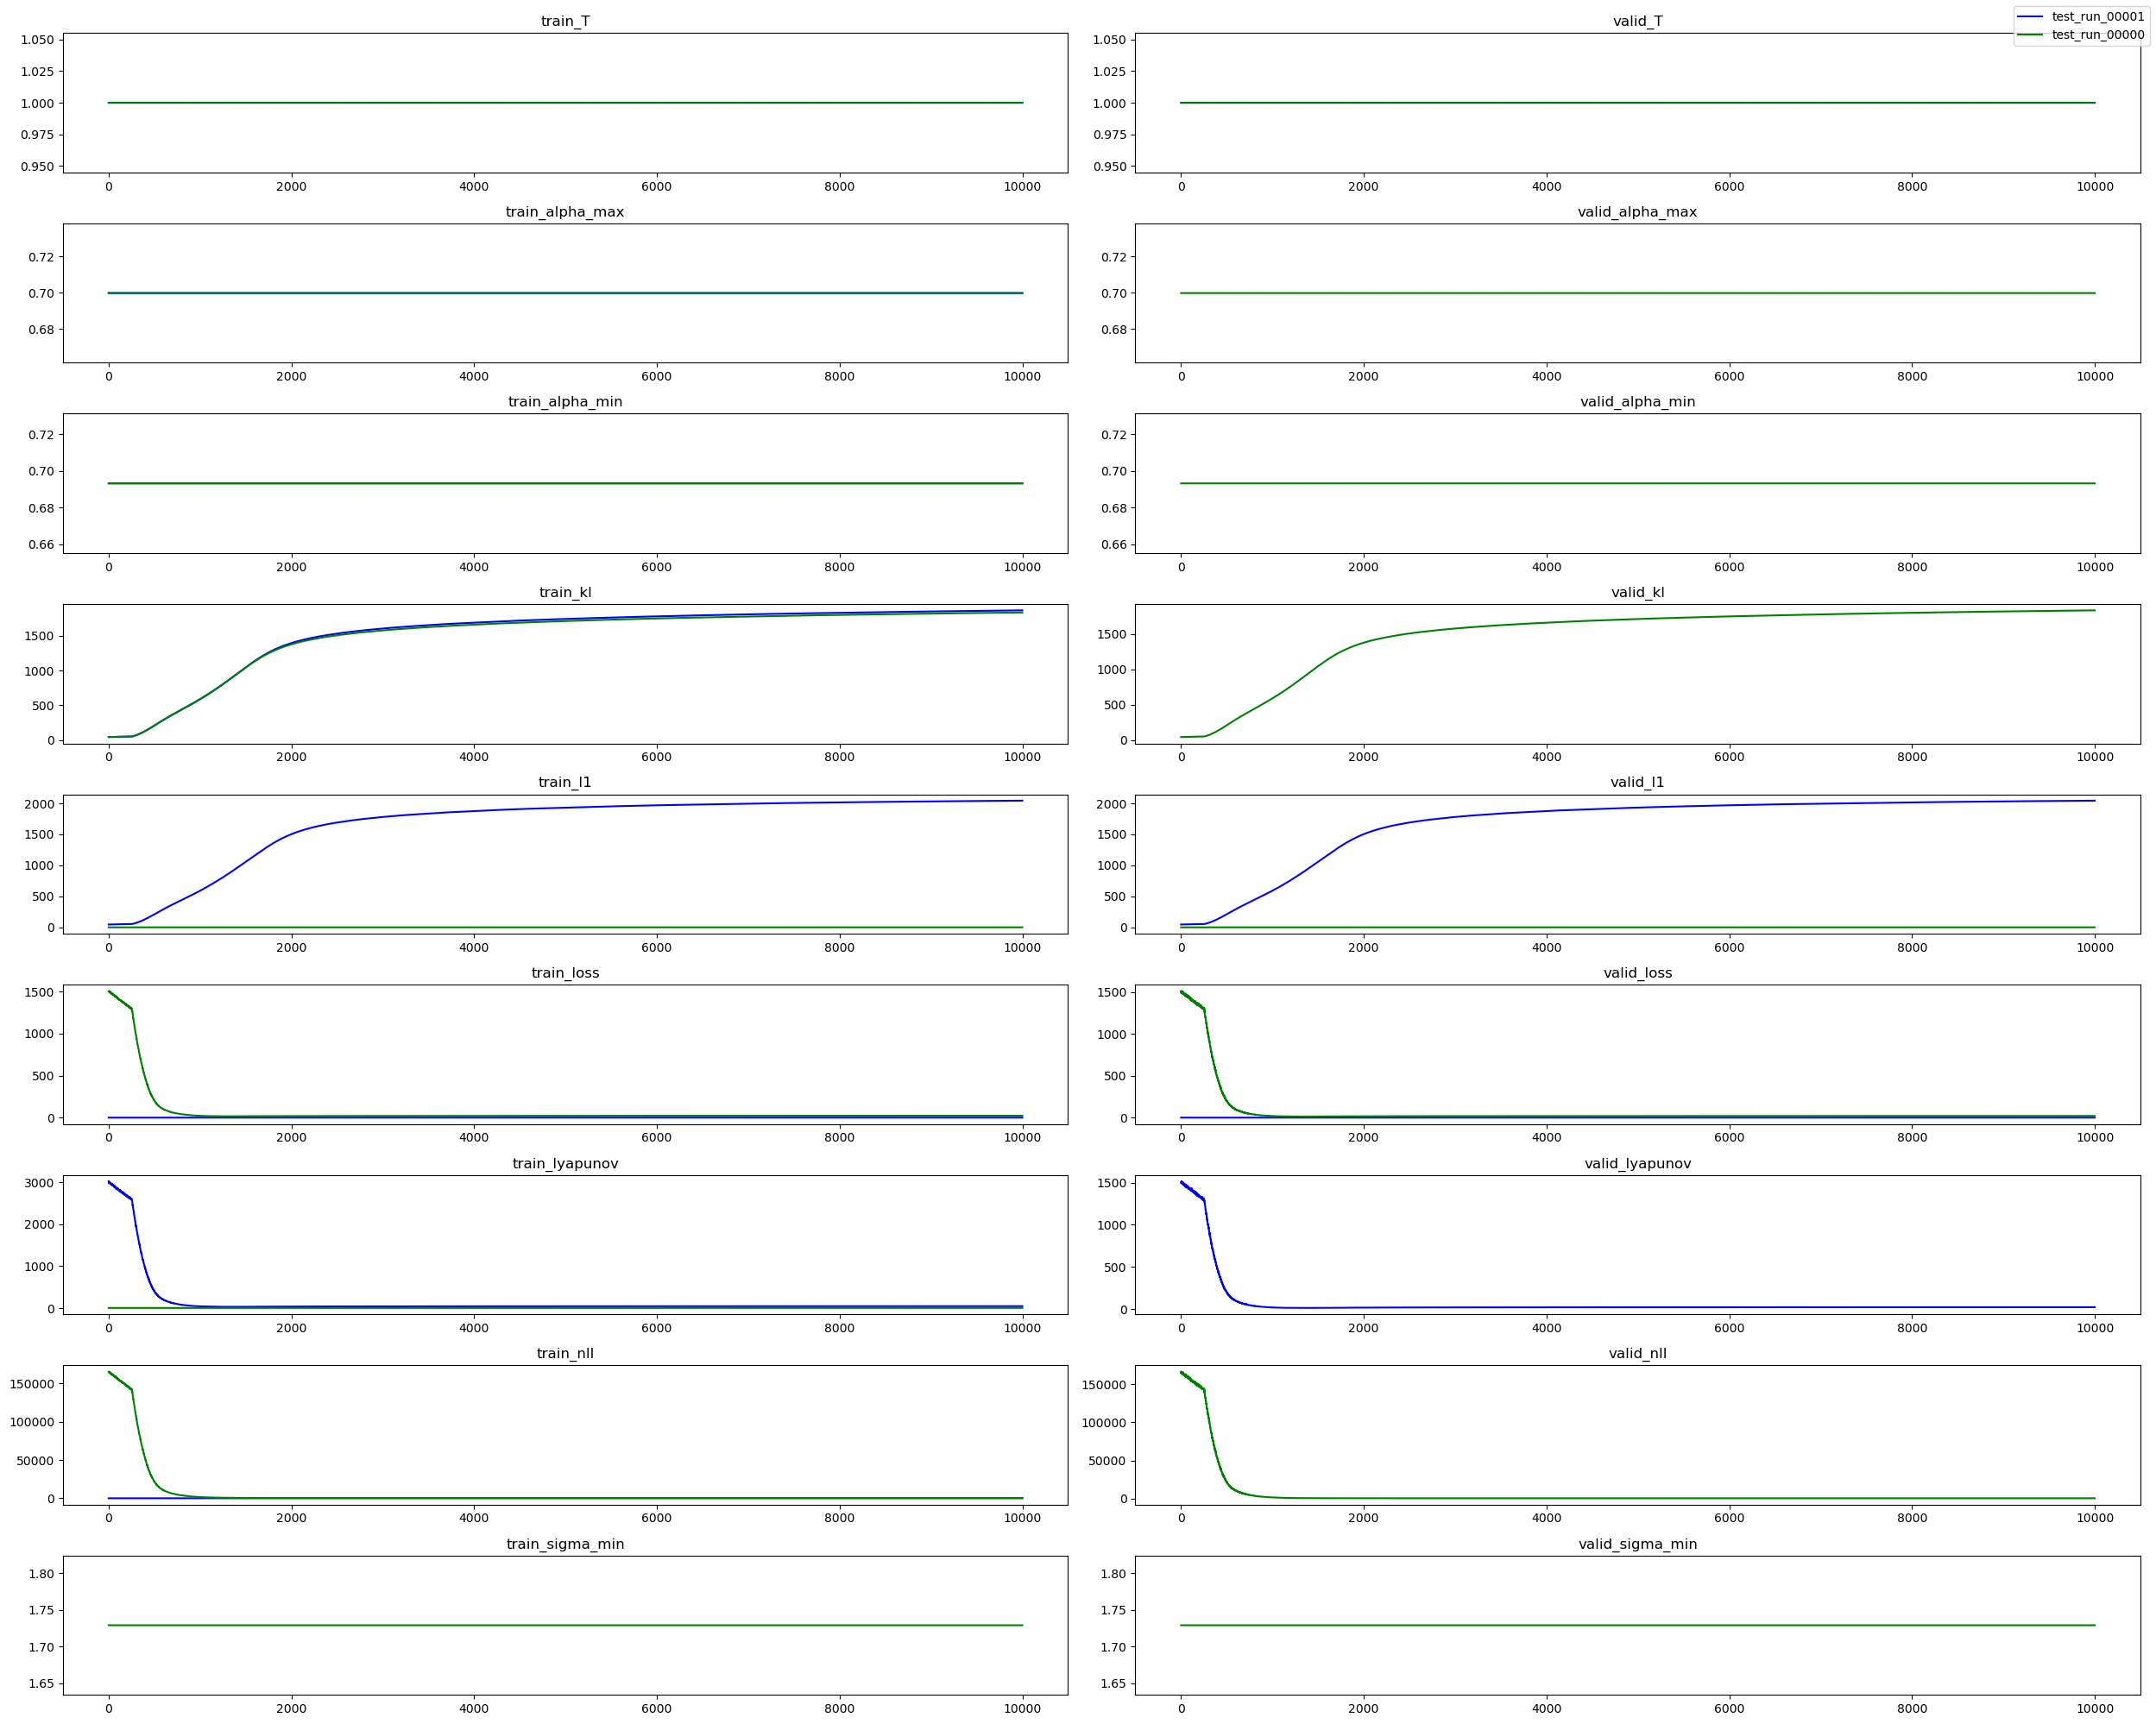

In [ ]:
fig, ax = plt.subplots(nrows=df.shape[1]//2, ncols=2, figsize = (25, 20))
for (key, df), color in zip(metrics.items(), mc.BASE_COLORS.keys()):
    
    for n,col in enumerate(df.columns):
        if n==df.shape[1]//2:
            break
        ax[n, 0].plot(df.index,
                   df[col],
                   label= key,
                   color=color)
        if "valid"+col[5:] in df.columns:
            ax[n, 1].plot(df.index,
                       df["valid"+col[5:]],
                       label= key,
                       color=color)
        ax[n, 0].set_title(col)
        ax[n, 1].set_title("valid"+col[5:])
    
h, l=ax[0,0].get_legend_handles_labels()
fig.legend(h,l)
fig.tight_layout()
fig.show()